### Instructions for setting up `DemandSupplySimulation` environment.

<p>Click to copy each command:</p>

1. **Open Terminal**  
   - Click on `Terminal` -> `New Terminal`

2. **Run Environment Creation Command**
   - Command: `conda env create -f environment.yml`  
     <button onclick="navigator.clipboard.writeText('conda env create -f environment.yml')">Copy Command</button>

3. **Update Existing Environment**  
   - Command: `conda env update -f environment.yml --prune`  
     <button onclick="navigator.clipboard.writeText('conda env update -f environment.yml --prune')">Copy Command</button>

4. **If `conda` is Not Available**  
   - Install conda mini.

### Frequently Used Commands


### メイン（データの読み込み⇒計算）

In [19]:
%reset -f
import pypsa, os, sys, importlib, shutil, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt
sys.path.append(os.getcwd())

# モジュールを強制的にリロード
import pypsa_tepsco
importlib.reload(pypsa_tepsco)

pd.set_option('display.max_columns', None)
os.makedirs('complete_network', exist_ok=True)
os.makedirs('combined_plots', exist_ok=True)

Year_of_analysis = 2024
demand_change_compared_to_2024 = 10  # %
file_name = "pypsa-japan-10BusModel.xlsx"  # ネットワーク＋需要データを含むExcelファイル

# Renewable Ninja API Key（取得方法: https://www.renewables.ninja/register）
renewable_ninja_api_key = "0ee68c7853037dcd2235f771d349d104e68996cf"  # ここにAPIキーを入力してください

# スナップショット作成
snapshots = pd.date_range(f"{Year_of_analysis}-01-01 00:00",
                          f"{Year_of_analysis}-01-31 23:00",
                          freq="h")
snapshots = snapshots[~((snapshots.month == 2) & (snapshots.day == 29))]

# ネットワークデータ読み込み
network = pypsa.Network(file_name)
network.set_snapshots(snapshots)

# 需要データ読み込み（同じExcelファイルの'Demand'シートから）
pypsa_tepsco.import_demand_data_from_network_file(network, file_name, demand_change_compared_to_2024)

# 太陽光発電データを自動取得
# networkのgeneratorsテーブルから太陽光発電所の座標(y, x)を自動抽出し、
# Renewable.ninja APIから時importlib.reload(pypsa_tepsco)系列データを取得
pypsa_tepsco.import_solar_data_from_renewable_ninja(
    network, 
    renewable_ninja_api_key, 
    Year_of_analysis, 
    Year_of_analysis
)

# 最適化実行
network.optimize(solver_name='highs')


INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores


Found 1 solar generators in network
Fetching data for '太陽光発電（東京）' at (35.67, 139.82), p_nom=100000.0 MW
  -> Received 8784 data points for '太陽光発電（東京）' (converted to JST)
✓ Successfully stored solar data for '太陽光発電（東京）' (744 points)

Summary: Successfully loaded data for 1/1 solar generators
  -> Received 8784 data points for '太陽光発電（東京）' (converted to JST)
✓ Successfully stored solar data for '太陽光発電（東京）' (744 points)

Summary: Successfully loaded data for 1/1 solar generators


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]
INFO:linopy.io: Writing time: 2.17s
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]
INFO:linopy.io: Writing time: 2.17s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 183768 primals, 374232 duals
Objective: 4.91e+11
Solver model: available
Solver message: Optimal

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 183768 primals, 374232 duals
Objective: 4.91e+11
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper were not assigned to the network.
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints G

('ok', 'optimal')

In [17]:
# 太陽光発電所のp_max_puを確認
print("=== 太陽光発電所の確認 ===")
solar_gens = network.generators[network.generators['carrier'] == '太陽光']
print(f"\n太陽光発電所の数: {len(solar_gens)}")
print(f"太陽光発電所: {solar_gens.index.tolist()}")

print("\n=== p_max_puの状態 ===")
for gen in solar_gens.index:
    if gen in network.generators_t.p_max_pu.columns:
        data = network.generators_t.p_max_pu[gen]
        print(f"{gen}: データ数={len(data)}, 非ゼロ={(data > 0).sum()}, 平均={data.mean():.4f}, 最大={data.max():.4f}")
    else:
        print(f"{gen}: p_max_puにデータなし")

print("\n=== p_max_pu全体の列 ===")
print(f"総列数: {len(network.generators_t.p_max_pu.columns)}")
print(f"列名: {network.generators_t.p_max_pu.columns.tolist()}")


=== 太陽光発電所の確認 ===

太陽光発電所の数: 1
太陽光発電所: ['太陽光発電（東京）']

=== p_max_puの状態 ===
太陽光発電（東京）: p_max_puにデータなし

=== p_max_pu全体の列 ===
総列数: 0
列名: []


In [ ]:
# 時刻のずれを確認するデバッグ
import pandas as pd

print("=== ネットワークのスナップショット（最初の10個）===")
print(network.snapshots[:10])

print("\n=== 太陽光データのインデックス（最初の10個）===")
solar_gen = network.generators[network.generators['carrier'] == '太陽光'].index[0]
if solar_gen in network.generators_t.p_max_pu.columns:
    # 元データのインデックスを表示
    print(f"発電所: {solar_gen}")
    print("データが格納されているインデックス:")
    print(network.generators_t.p_max_pu.index[:10])
    
    print("\n=== 太陽光発電の値（最初の24時間）===")
    data_24h = network.generators_t.p_max_pu[solar_gen][:24]
    for i, (time, val) in enumerate(data_24h.items()):
        print(f"{time}: {val:.4f}")
else:
    print("太陽光データが見つかりません")

In [18]:
# モジュールキャッシュをクリアして完全にリロード
import sys
import importlib

# モジュールをシステムから削除
if 'pypsa_tepsco' in sys.modules:
    del sys.modules['pypsa_tepsco']

# 再インポート
import pypsa_tepsco

print("モジュールを完全にリロードしました\n")

# 手動で関数を実行してテスト
print("=== 手動で太陽光データ取得を実行 ===\n")
pypsa_tepsco.import_solar_data_from_renewable_ninja(
    network, 
    renewable_ninja_api_key, 
    Year_of_analysis, 
    Year_of_analysis
)
print("\n=== 実行完了 ===")


モジュールを完全にリロードしました

=== 手動で太陽光データ取得を実行 ===

Found 1 solar generators in network
Fetching data for '太陽光発電（東京）' at (35.67, 139.82), p_nom=100000.0 MW
  -> Received 8784 data points for '太陽光発電（東京）' (converted to JST)
✓ Successfully stored solar data for '太陽光発電（東京）' (744 points)

Summary: Successfully loaded data for 1/1 solar generators

=== 実行完了 ===
  -> Received 8784 data points for '太陽光発電（東京）' (converted to JST)
✓ Successfully stored solar data for '太陽光発電（東京）' (744 points)

Summary: Successfully loaded data for 1/1 solar generators

=== 実行完了 ===


In [8]:
# APIリクエストを直接テスト（完全修正版）
import requests

# 太陽光発電所の情報を取得
solar_gen = network.generators[network.generators['carrier'] == '太陽光'].iloc[0]
lat, lon = solar_gen['y'], solar_gen['x']

# テストURL（必要なパラメータを全て追加）
# tracking=0: 固定式, azim=180: 南向き, tilt=35: 傾斜角35度, system_loss=0.1: システム損失10%（0.1 = 10%）
test_url = f"https://www.renewables.ninja/api/data/pv?lat={lat}&lon={lon}&capacity=1&tracking=0&azim=180&tilt=35&system_loss=0.1&date_from={Year_of_analysis}-01-01&date_to={Year_of_analysis}-01-31&format=json"

print(f"テスト用URL: {test_url[:120]}...")
print(f"\nパラメータ:")
print(f"  lat={lat}, lon={lon}")
print(f"  capacity=1")
print(f"  tracking=0 (固定式)")
print(f"  azim=180 (南向き)")
print(f"  tilt=35 (傾斜角)")
print(f"  system_loss=0.1 (損失10% - 修正済み)")
print(f"  date: {Year_of_analysis}-01-01 to {Year_of_analysis}-01-31")

# APIキーはヘッダーで渡す（正しい方法）
headers = {'Authorization': f'Token {renewable_ninja_api_key}'}
response = requests.get(test_url, headers=headers)

print(f"\nレスポンスコード: {response.status_code}")

if response.status_code == 200:
    data = response.json()
    print(f"✓ 成功！")
    print(f"\nレスポンスのキー: {list(data.keys())}")
    print(f"\nレスポンス内容（最初の500文字）:\n{str(data)[:500]}")
    
    # データ構造を確認
    if 'data' in data:
        print(f"\n'data'キーの型: {type(data['data'])}")
        if isinstance(data['data'], list) and len(data['data']) > 0:
            print(f"リストの最初の要素: {data['data'][0]}")
        elif isinstance(data['data'], dict):
            print(f"辞書のキー: {list(data['data'].keys())[:10]}")
else:
    print(f"✗ エラー: {response.text[:500]}")


テスト用URL: https://www.renewables.ninja/api/data/pv?lat=35.67&lon=139.82&capacity=1&tracking=0&azim=180&tilt=35&system_loss=0.1&dat...

パラメータ:
  lat=35.67, lon=139.82
  capacity=1
  tracking=0 (固定式)
  azim=180 (南向き)
  tilt=35 (傾斜角)
  system_loss=0.1 (損失10% - 修正済み)
  date: 2024-01-01 to 2024-01-31

レスポンスコード: 200
✓ 成功！

レスポンスのキー: ['metadata', 'data']

レスポンス内容（最初の500文字）:
{'metadata': {'units': {'time': 'UTC', 'electricity': 'kW'}, 'params': {'lat': '35.67', 'lon': '139.82', 'capacity': '1', 'tracking': '0', 'azim': '180', 'tilt': '35', 'system_loss': '0.1', 'date_from': '2024-01-01', 'date_to': '2024-01-31'}}, 'data': {'1704067200000': {'electricity': 0.56}, '1704070800000': {'electricity': 0.667}, '1704074400000': {'electricity': 0.705}, '1704078000000': {'electricity': 0.696}, '1704081600000': {'electricity': 0.616}, '1704085200000': {'electricity': 0.465}, '1

'data'キーの型: <class 'dict'>
辞書のキー: ['1704067200000', '1704070800000', '1704074400000', '1704078000000', '1704081600000', '17040852

In [16]:
network.export_to_excel(f'complete_network/complete_network_{Year_of_analysis}.xlsx')

INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to 'complete_network\complete_network_2024.xlsx contains: sub_networks, loads, buses, links, carriers, generators


# 送電線の潮流を表示

<Axes: title={'center': 'Power Flow in Transmission Lines'}, xlabel='snapshot'>

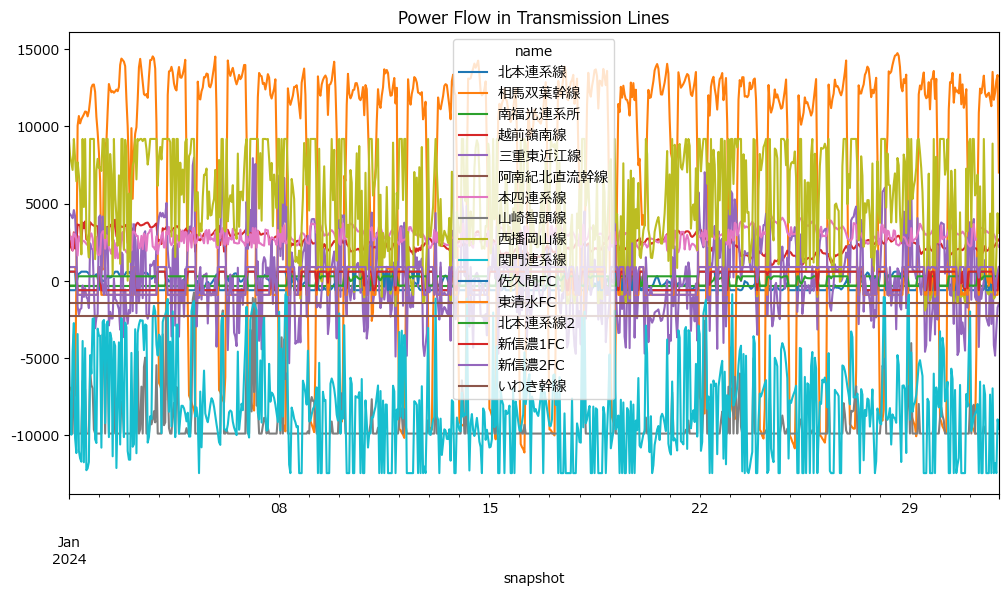

In [15]:
pd.options.plotting.backend = "matplotlib"  # プロットバックエンドをmatplotlibに
plt.rcParams['font.family'] = 'Meiryo'  # または 'Meiryo', 'Yu Gothic' MS Gothic
plt.rcParams['axes.unicode_minus'] = False  # マイナス符号も文字化け防止
network.links_t.p0.plot(title="Power Flow in Transmission Lines", figsize=(12, 6))

# 発電出力を表示

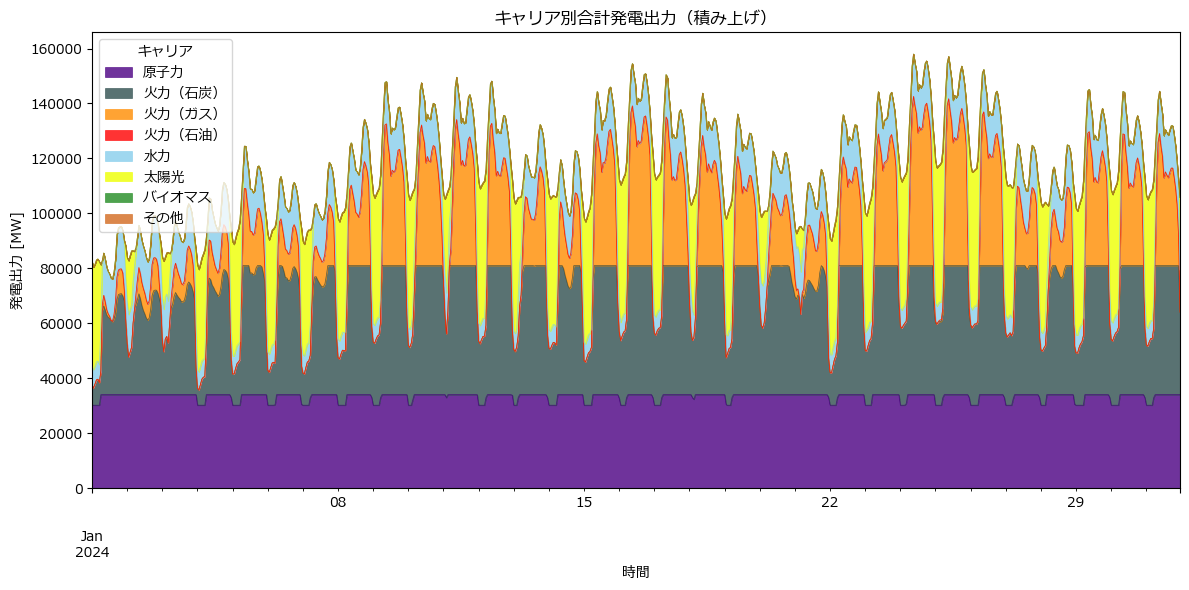

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
pd.options.plotting.backend = "matplotlib"  # プロットバックエンドをmatplotlibに
plt.rcParams['font.family'] = 'Meiryo'  # または 'Meiryo', 'Yu Gothic' MS Gothic
plt.rcParams['axes.unicode_minus'] = False  # マイナス符号も文字化け防止
# 各generatorがどのcarrierかを取得
carrier_map = network.generators['carrier']

# generator名→carrier名の辞書
gen_to_carrier = carrier_map.to_dict()

# generators_t.pの列（generator名）ごとにcarrierでgroupbyして合計
carrier_output = {}
for gen, carrier in gen_to_carrier.items():
    if carrier not in carrier_output:
        carrier_output[carrier] = network.generators_t.p[gen]
    else:
        carrier_output[carrier] += network.generators_t.p[gen]

# DataFrame化（index=時系列、columns=carrier）
import pandas as pd
carrier_output_df = pd.DataFrame(carrier_output)

# グラフ描画
# キャリアの順序および色を指定（下から上に積み上がる順）
desired_order = ["原子力", "火力（石炭）", "火力（ガス）", "火力（石油）", "水力", "太陽光", "バイオマス", "その他"]
color_list = ["#4B0082", "#2F4F4F", "#FF8C00", "#FF0000", "#87CEEB", "#EEFF00", "#228B22", "#D2691E"]
# 指定順で列を並び替える（存在する列だけ抽出）
ordered_columns = [col for col in desired_order if col in carrier_output_df.columns]
carrier_output_df = carrier_output_df[ordered_columns]

# グラフ描画
carrier_output_df.plot(
    kind="area", 
    stacked=True, 
    figsize=(12,6),
    alpha=0.8,
    color=color_list[:len(ordered_columns)],
    linewidth=0.5
)
plt.title("キャリア別合計発電出力（積み上げ）")
plt.xlabel("時間")
plt.ylabel("発電出力 [MW]")
plt.legend(title="キャリア")
plt.tight_layout()
plt.show()


In [ ]:
network.export_to_hdf5('complete_network/unsolved_model.h5')

# 地図上にプロットする。

In [ ]:
import folium
import pandas as pd

# Helper: try various column names and return DataFrame with lat/lon
def _get_bus_locations_df(network):
    df = network.buses.copy()
    # common PyPSA default: x (lon), y (lat)
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    # already lat/lon
    elif {'lat','lon'}.issubset(df.columns):
        pass
    # alternative naming
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    # some workflows store coords in a list/tuple column called 'coords'
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    # ensure numeric and drop invalid rows
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# get bus locations (raises helpful error if not found)
bus_locations = _get_bus_locations_df(network)

# 地図の中心をバスの平均位置に設定
center_lat = bus_locations['lat'].mean()
center_lon = bus_locations['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# バスごとにマーカーを追加
for bus_name, row in bus_locations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=str(bus_name),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# 保存と表示
m.save('bus_locations_map.html')

m

In [ ]:
# プロット: バスとリンク（network.links / network.lines）を地図上に描画して保存
# 既に folium, network, Year_of_analysis が定義されている前提
import folium

# 再利用可能なバス位置取得関数 (cell '#VSC-50c70af2' と同じロジック)
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# バス位置取得
bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        # bus 名が bus_locations にあるか確認
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

# network.links があれば描画
links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

# network.lines があれば描画（存在するネットワークでは lines が無い場合もある）
if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

# 出力・保存
out_file = f'bus_links_map_{Year_of_analysis}.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

# Jupyter で表示するためにマップオブジェクトを返す
m_links


In [ ]:
# Duplicate plotting cell made robust as well
import folium

# re-use the helper from earlier; define again to be safe in isolation
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

out_file = f'bus_links_map_{Year_of_analysis}.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

m_links
